In [8]:
# all imports
import pandas as pd
import numpy as np
import seaborn as sns
import time
import itertools
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import os.path

In [12]:
if os.path.isfile("bar_data.csv"):
    bar_data = pd.read_csv("bar_data.csv", index_col=0)
else:
    # Read data
    data = pd.read_csv("Training Data_PERPOC.csv")

    # Let's do the analysis for 'Bar'
    bar_data = data.loc[data['SEGMENT_POC'] == 'Bar'].copy()

    # Choose the right features
    features = ['YEAR', 'MONTH', 'DAY', 'COD_POC', 'SEGMENT_POC', 'DISCOUNT',
               'COUNTPOC', 'COD_PROD', 'FACTOR_HL', 'COD_ACOB', 'COD_COMBO',
               'COD_ACAO', 'WEEKOFMONTH', 'DAYOFWEEK', 'SAZ_MX', 'SAZ_DWX', 'SAZ_WMX',
               'POL_PTR', 'VOLPRODDAY', 'SUMMER', 'TEMPMAX', 'TEMPMIN', 'TEMPAVG',
               'HUMAVG', 'PRECIP', 'TEMPMAX_D+1', 'TEMPMAX_D-1', 'TEMPMAX_D+2',
               'TEMPMAX_D-2', 'TEMPMAX_D+3', 'TEMPMAX_D-3', 'TEMPMIN_D+1',
               'TEMPMIN_D-1', 'TEMPMIN_D+2', 'TEMPMIN_D-2', 'TEMPMIN_D+3',
               'TEMPMIN_D-3', 'TEMPAVG_D+1', 'TEMPAVG_D-1', 'TEMPAVG_D+2',
               'TEMPAVG_D-2', 'TEMPAVG_D+3', 'TEMPAVG_D-3', 'HUMAVG_D+1', 'HUMAVG_D-1',
               'HUMAVG_D+2', 'HUMAVG_D-2', 'HUMAVG_D+3', 'HUMAVG_D-3', 'PRECIP_D+1',
               'PRECIP_D-1', 'PRECIP_D+2', 'PRECIP_D-2', 'PRECIP_D+3', 'PRECIP_D-3',
               'SPECIAL_DATE', 'SPECIAL_DATE_D+1', 'SPECIAL_DATE_D-1',
               'SPECIAL_DATE_D+2', 'SPECIAL_DATE_D-2', 'SPECIAL_DATE_D+3',
               'SPECIAL_DATE_D-3', 'ICC', 'ICEA', 'INEC', 'INPC', 'INPC_AB', 'IPCA',
               'IPCA_AB', 'AVERAGEYIELD', 'SELIC_MONTH', 'UNEMPLOYMENTRATE', 'ICC_m-1',
               'ICEA_m-1', 'INEC_m-1', 'INPC_m-1', 'INPC_AB_m-1', 'IPCA_m-1',
               'IPCA_AB_m-1', 'AVERAGEYIELD_m-1', 'SELIC_MONTH_m-1',
               'UNEMPLOYMENTRATE_m-1', 'REPASSE', 'REPASSE+1', 'REPASSE-1']

    # Create a `DATE` column
    bar_data.insert(0, 'DATE', pd.to_datetime(bar_data[['YEAR', 'MONTH', 'DAY']]))

    # Create a `PTR` column, which takes into account the discount
    bar_data["PTR"] = bar_data["POL_PTR"] * (1 + bar_data["DISCOUNT"])

    # Sort the data set on the basis of time
    bar_data.sort_values(['YEAR', 'MONTH', 'DAY'], ascending=[True, True, True], inplace=True)

    # Create `MONTH` dummies
    bar_data = pd.concat([bar_data, pd.get_dummies(bar_data["MONTH"], prefix="MONTH")], axis=1)

    # Create `WEEK` dummies
    bar_data = pd.concat([bar_data, pd.get_dummies(bar_data["WEEKOFMONTH"], prefix="WEEK")], axis=1)

    # Create `DAYOFWEEK` dummies
    bar_data = pd.concat([bar_data, pd.get_dummies(bar_data["DAYOFWEEK"], prefix="DAYOFWEEK")], axis=1)

    # Create `NEARWEEKEND` dummy
    bar_data["NEARWEEKEND"] = bar_data["DAYOFWEEK_0"] | bar_data["DAYOFWEEK_6"] | bar_data["DAYOFWEEK_5"] | bar_data["DAYOFWEEK_4"]

    # Create `VOLPRODDAYWEEKSKU` across all PoCs
    vol_sku_week = bar_data.groupby(["MONTH", "WEEKOFMONTH", "COD_PROD"])["VOLPRODDAY"].agg('sum').reset_index()
    bar_data = bar_data.merge(right=vol_sku_week, how="left", on=["MONTH", "WEEKOFMONTH", "COD_PROD"], suffixes=["", "WEEKSKU"])

    # Create `VOLPRODDAYWEEK` for each PoC
    vol_sku_week = bar_data.groupby(["MONTH", "WEEKOFMONTH", "COD_POC"])["VOLPRODDAY"].agg('sum').reset_index()
    bar_data = bar_data.merge(right=vol_sku_week, how="left", on=["MONTH", "WEEKOFMONTH", "COD_POC"], suffixes=["", "WEEK"])

    # Perform log transforms for the volumes
    bar_data["LOG_VOLPRODDAY"] = np.log(bar_data["VOLPRODDAY"])
    bar_data["LOG_VOLPRODDAYWEEK"] = np.log(bar_data["VOLPRODDAYWEEK"])
    bar_data["LOG_VOLPRODDAYWEEKSKU"] = np.log(bar_data["VOLPRODDAYWEEKSKU"])

    # Perform log tranform for PTR
    bar_data["LOG_PTR"] = np.log(bar_data["PTR"])
    bar_data["LOG_POL_PTR"] = np.log(bar_data["POL_PTR"])

    # Create `DAYSINMONTH`
    bar_data["DAYSINMONTH"] = np.where(bar_data["MONTH"].isin([1, 3, 5, 7, 8, 10, 12]), 31, 30)
    bar_data["DAYSINMONTH"] = np.where(bar_data["MONTH"] == 2, 28, bar_data["DAYSINMONTH"])

    # Create a `POC_STOCK` column for each PoC
    # Get the assumed mean daily sales, when I assume every month, `total sales` = `total purchase`
    monthly_sales = bar_data.groupby(["YEAR", "MONTH", "COD_POC"])["VOLPRODDAY"].agg('sum').reset_index()
    bar_data = bar_data.merge(right=monthly_sales, how="left", on=["YEAR", "MONTH", "COD_POC"], suffixes=["", "_MEAN"])
    bar_data["VOLPRODDAY_MEAN"] /= bar_data["DAYSINMONTH"]

    # Get the `SALESTODATE`, which is according to our "monthly" assumption
    bar_data["SALESTODATE"] = bar_data["VOLPRODDAY_MEAN"] * bar_data["DAY"]

    # Get the `PURCHASETODATE`
    daily_purchase = bar_data.groupby(["YEAR", "MONTH", "DAY", "COD_POC"])["VOLPRODDAY"].agg('sum').reset_index()
    daily_purchase["PURCHASETODATE"] = daily_purchase.groupby(["YEAR", "MONTH", "COD_POC"])["VOLPRODDAY"].apply(lambda x: x.cumsum()).values
    daily_purchase["PURCHASETODATE"] = daily_purchase.groupby(["COD_POC"])["PURCHASETODATE"].apply(lambda x: x.shift(1))
    daily_purchase = daily_purchase.sort_values(["COD_POC", "YEAR", "MONTH", "DAY"]).reset_index()

    # Set the first entry in `PURCHASETODATE` for every month to 0
    for i in range(1, daily_purchase.shape[0]):
        if i == 1:
            daily_purchase.loc[i - 1, "PURCHASETODATE"] = 0

        if ((daily_purchase["MONTH"][i - 1] != daily_purchase["MONTH"][i]) or 
            (daily_purchase["COD_POC"][i - 1] != daily_purchase["COD_POC"][i])):
            daily_purchase.loc[i, "PURCHASETODATE"] = 0

    # Merge to POC data
    bar_data = bar_data.merge(right=daily_purchase, how="left", on=["YEAR", "MONTH", "DAY", "COD_POC"], suffixes=["", "_DAILY"])

    # Create the `POC_STOCK` column
    bar_data["POC_STOCK"] = bar_data["PURCHASETODATE"] - bar_data["SALESTODATE"]
    
    # Save the bar_data for future use
    bar_data.to_csv("bar_data.csv")

In [13]:
features = [
             # Engineered features
             "POC_STOCK",
             "LOG_PTR",
             # "LOG_POL_PTR",
             'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_11', 'MONTH_12',
             "WEEK_1", "WEEK_2", "WEEK_3", "WEEK_4", "WEEK_5",
             "DAYOFWEEK_0", "DAYOFWEEK_1", "DAYOFWEEK_2", "DAYOFWEEK_3", "DAYOFWEEK_4", "DAYOFWEEK_5",
             "NEARWEEKEND",
             "LOG_VOLPRODDAYWEEK",
             "LOG_VOLPRODDAYWEEKSKU",

             # All features which were already present   
             'COD_POC',
             # 'DISCOUNT',
             'COUNTPOC', 
             #'COD_PROD', 
             'FACTOR_HL', 'COD_ACOB', 'COD_COMBO',
             'COD_ACAO', 
             # 'WEEKOFMONTH', 
             #'DAYOFWEEK', 
             'SAZ_MX', 'SAZ_DWX', 'SAZ_WMX',
             # 'POL_PTR', 
             'SUMMER', 'TEMPMAX', 'TEMPMIN', 'TEMPAVG',
             'HUMAVG', 'PRECIP', 
             #'TEMPMAX_D+1', 'TEMPMAX_D-1', 'TEMPMAX_D+2',
             #'TEMPMAX_D-2', 
             #'TEMPMAX_D+3', 'TEMPMAX_D-3', 'TEMPMIN_D+1',
             #'TEMPMIN_D-1', 'TEMPMIN_D+2', 'TEMPMIN_D-2', 'TEMPMIN_D+3',
             #'TEMPMIN_D-3', 'TEMPAVG_D+1', 'TEMPAVG_D-1', 'TEMPAVG_D+2',
             #'TEMPAVG_D-2', 'TEMPAVG_D+3', 'TEMPAVG_D-3', 'HUMAVG_D+1', 'HUMAVG_D-1',
             #'HUMAVG_D+2', 'HUMAVG_D-2', 'HUMAVG_D+3', 'HUMAVG_D-3', 'PRECIP_D+1',
             #'PRECIP_D-1', 'PRECIP_D+2', 'PRECIP_D-2', 'PRECIP_D+3', 'PRECIP_D-3',
             'SPECIAL_DATE', 'SPECIAL_DATE_D+1', 'SPECIAL_DATE_D-1',
             'SPECIAL_DATE_D+2', 'SPECIAL_DATE_D-2', 'SPECIAL_DATE_D+3',
             'SPECIAL_DATE_D-3', 'ICC', 'ICEA', 'INEC', 'INPC', 'INPC_AB', 'IPCA',
             'IPCA_AB', 'AVERAGEYIELD', 'SELIC_MONTH', 'UNEMPLOYMENTRATE', 'ICC_m-1',
             'ICEA_m-1', 'INEC_m-1', 'INPC_m-1', 'INPC_AB_m-1', 'IPCA_m-1',
             'IPCA_AB_m-1', 'AVERAGEYIELD_m-1', 'SELIC_MONTH_m-1',
             'UNEMPLOYMENTRATE_m-1', 
             
             'REPASSE', 'REPASSE+1', 'REPASSE-1'
        ]

model_data = bar_data[bar_data["COD_PROD"] == 9886]

X = model_data[features]
# Remove features which are always 0
X = X.loc[:, (X != 0).any(axis=0)]
y = model_data["LOG_VOLPRODDAY"]

# This is a base model, taking all features
# Run an OLS model
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         LOG_VOLPRODDAY   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     1378.
Date:                Mon, 01 Oct 2018   Prob (F-statistic):               0.00
Time:                        16:06:52   Log-Likelihood:                -81181.
No. Observations:               92531   AIC:                         1.625e+05
Df Residuals:                   92486   BIC:                         1.629e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
POC_STOCK                -0.05

In [85]:
iteration = 0
while True:
    
    print("Iteration: %d" % (iteration))
    iteration += 1
    
    X = model_data[features]
    # Remove features which are always 0
    X = X.loc[:, (X != 0).any(axis=0)]
    y = model_data["LOG_VOLPRODDAY"]

    # Run an OLS model
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()

    # Make predictions using the testing set
    # y_pred = model.predict(X_test)
    # print("=" * 120)
    print("Coefficient of LOG_PTR is", results.params["LOG_PTR"], "& its pvalue is", results.pvalues["LOG_PTR"])
    max_pvalue = max(results.pvalues[(results.pvalues.index != "LOG_POL_PTR") 
                                     & (results.pvalues.index != "DISCOUNT")
                                     & (results.pvalues.index != "LOG_PTR")
                                     & (results.pvalues.index != "const")])
    if max_pvalue <= 0.10:
        print(results.summary())
        break
    
    feature_removed = results.pvalues.index[results.pvalues == max_pvalue].tolist()[0]
    features.remove(feature_removed)
    print("Feature removed is ", end="")
    print(feature_removed)

Iteration: 0
Coefficient of LOG_PTR is -1.1560331370316526 & its pvalue is 0.0
Feature removed is SUMMER
Iteration: 1
Coefficient of LOG_PTR is -1.1560331370155912 & its pvalue is 0.0
Feature removed is SPECIAL_DATE_D+1
Iteration: 2
Coefficient of LOG_PTR is -1.1560178193157375 & its pvalue is 0.0
Feature removed is NEARWEEKEND
Iteration: 3
Coefficient of LOG_PTR is -1.1560178193370811 & its pvalue is 0.0
Feature removed is SPECIAL_DATE_D+2
Iteration: 4
Coefficient of LOG_PTR is -1.156020720951665 & its pvalue is 0.0
Feature removed is SPECIAL_DATE_D-3
Iteration: 5
Coefficient of LOG_PTR is -1.1559775236212233 & its pvalue is 0.0
Feature removed is COUNTPOC
Iteration: 6
Coefficient of LOG_PTR is -1.1559775235745233 & its pvalue is 0.0
Feature removed is AVERAGEYIELD_m-1
Iteration: 7
Coefficient of LOG_PTR is -1.1559775236024712 & its pvalue is 0.0
Feature removed is IPCA
Iteration: 8
Coefficient of LOG_PTR is -1.1559775236390049 & its pvalue is 0.0
Feature removed is SPECIAL_DATE_D+3
I

In [92]:
# Best Subset Selection &
# Forward & Backward Stepwise Selection
# source = "http://www.science.smith.edu/~jcrouser/SDS293/labs/2016/lab8/Lab%208%20-%20Subset%20Selection%20in%20Python.pdf"

X = model_data[features]
X = X.loc[:, (X != 0).any(axis=0)]
y = model_data["LOG_VOLPRODDAY"]

def process_subset(feature_set):
    # Fit model on feature set & calculate the RSS
    model = sm.OLS(y, X[list(feature_set)])
    results = model.fit()
    rss = ((results.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model": results, "rss": rss}


def get_best(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(process_subset(list(combo)))
    models = pd.DataFrame(results)
    best_model = models.loc[models["rss"].values.argmin()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", k + 1, "predictors in", toc - tic, "seconds.")
    return best_model


def forward(predictors):
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(process_subset(predictors + [p]))
    models = pd.DataFrame(results)
    best_model = models.loc[models["rss"].idxmin()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", len(predictors) + 1, "predictors in", toc - tic, "seconds.")
    return best_model


def backward(predictors):
    tic = time.time()
    results = []
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(process_subset(combo))
    models = pd.DataFrame(results)
    best_model = models.loc[models["rss"].idxmin()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", len(predictors) - 1, "predictors in", toc - tic, "seconds.")
    return best_model


def forward_stepwise_selection():
    models = pd.DataFrame(columns=["rss", "model"])
    tic = time.time()
    predictors = []
    for i in range(1, len(X.columns) + 1):
        models.loc[i] = forward(predictors)
        predictors = models.loc[i]["model"].model.exog_names
    toc = time.time()
    print("Total elapsed time:", toc - tic, "seconds.")
    return models


def backward_stepwise_selection():
    models = pd.DataFrame(columns=["rss", "model"], index=range(1, len(X.columns)))
    tic = time.time()
    predictors = X.columns
    while len(predictors) > 1:
        models.loc[len(predictors) - 1] = backward(predictors)
        predictors = models.loc[len(predictors) - 1]["model"].model.exog_names
    toc = time.time()
    print("Total elapsed time:", toc - tic, "seconds.")
    return models


def best_subset_selection(till):
    models = pd.DataFrame(columns=["rss", "model"])
    tic = time.time()
    for i in range(1, till + 1):
        models.loc[i] = get_best(i)
    toc = time.time()
    print("Total elapsed time:", toc - tic, "seconds.")
    return models


models_forward = forward_stepwise_selection()
models_backward = backward_stepwise_selection()

# Look at the features in the `best` models, on basis of ajusted R squared
k_forward = models_forward.apply(lambda row: row[1].rsquared_adj, axis=1).idxmax()
k_backward = models_backward.apply(lambda row: row[1].rsquared_adj, axis=1).idxmax()
features_forward = models_forward.loc[k_forward, "model"].model.exog_names
features_backward = models_backward.loc[k_backward, "model"].model.exog_names
features = list(set(features_forward).intersection(features_backward)) + ["LOG_PTR"]
print("Final features are",  list(set(features)))

# Save the models as pickle files
models_forward.to_pickle("models_forward.pkl")
models_backward.to_pickle("models_backward.pkl")

# models = best_subset_selection(till=4)

Processed 68 models on 1 predictors in 0.5712814331054688 seconds.
Processed 67 models on 2 predictors in 0.6838810443878174 seconds.
Processed 66 models on 3 predictors in 0.9156770706176758 seconds.
Processed 65 models on 4 predictors in 1.1816630363464355 seconds.
Processed 64 models on 5 predictors in 1.5189859867095947 seconds.
Processed 63 models on 6 predictors in 1.7741224765777588 seconds.
Processed 62 models on 7 predictors in 2.0707881450653076 seconds.
Processed 61 models on 8 predictors in 2.349815607070923 seconds.
Processed 60 models on 9 predictors in 2.726727247238159 seconds.
Processed 59 models on 10 predictors in 3.446085214614868 seconds.
Processed 58 models on 11 predictors in 4.332046270370483 seconds.
Processed 57 models on 12 predictors in 4.358542203903198 seconds.
Processed 56 models on 13 predictors in 4.7629735469818115 seconds.
Processed 55 models on 14 predictors in 4.297386884689331 seconds.
Processed 54 models on 15 predictors in 5.6479339599609375 seco

Processed 14 models on 13 predictors in 1.6751458644866943 seconds.
Processed 13 models on 12 predictors in 1.3301215171813965 seconds.
Processed 12 models on 11 predictors in 1.1423962116241455 seconds.
Processed 11 models on 10 predictors in 0.9104056358337402 seconds.
Processed 10 models on 9 predictors in 0.7095527648925781 seconds.
Processed 9 models on 8 predictors in 0.5824718475341797 seconds.
Processed 8 models on 7 predictors in 0.3994266986846924 seconds.
Processed 7 models on 6 predictors in 0.29926609992980957 seconds.
Processed 6 models on 5 predictors in 0.21894145011901855 seconds.
Processed 5 models on 4 predictors in 0.1423943042755127 seconds.
Processed 4 models on 3 predictors in 0.1006462574005127 seconds.
Processed 3 models on 2 predictors in 0.0497136116027832 seconds.
Processed 2 models on 1 predictors in 0.02249455451965332 seconds.
Total elapsed time: 1502.8226590156555 seconds.
Final features are ['POC_STOCK', 'LOG_VOLPRODDAYWEEK', 'MONTH_11', 'SPECIAL_DATE_D

In [14]:
print("Best model from forward selection: ")
print(models_forward.loc[k_forward, "model"].summary())
print("*" * 130)
print("Best model from backward selection: ")
print(models_backward.loc[k_backward, "model"].summary())

Best model from forward selection: 


NameError: name 'models_forward' is not defined

/home/saubhik/py3env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


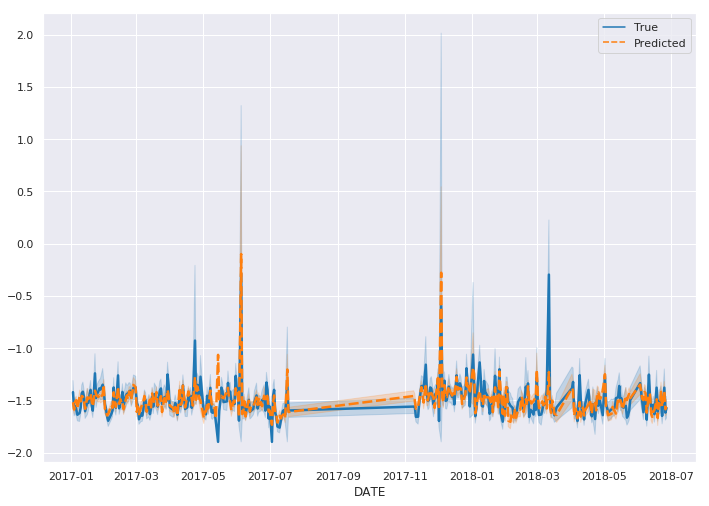

In [104]:
best_model = models_backward.loc[k_backward, "model"]
dates = model_data['DATE']
values = pd.concat([y, pd.Series(best_model.predict(model_data[best_model.model.exog_names]), index=y.index)], axis=1).values
data = pd.DataFrame(values, dates, columns=["True", "Predicted"])
sns.lineplot(data=data, palette="tab10", linewidth=2.5)